In [1]:
#----------------------------------------------------------------
# Load libraries
#----------------------------------------------------------------
import numpy as np
import math
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

%matplotlib inline

# [Hidden code]: Define the model function w(t) here.
def osc(t, Mc, t0, C, phi):


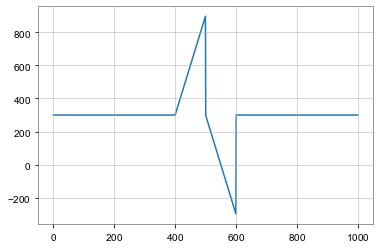

In [2]:
print('# [Hidden code]: Define the model function w(t) here.')
print('def osc(t, Mc, t0, C, phi):')

#----------------------------------------------------------------
# Wave form analytic
#----------------------------------------------------------------
def spike(t,offset,slope,t0):
    val = offset
    val = val + (t-(t0-100))*slope*(t>=t0-100)*(t<=t0) - (t-t0)*slope*(t>t0)*(t<=(t0+100))
    return val 

### Build some toy data ###
### 1000 time steps with this glitch centered at 500 ###
vals =[]
sample_times = np.linspace(0,1000,1000)
for t in sample_times:
    vals.append(spike(t,300,6,500))
toy_data = vals
plt.plot(sample_times, vals)
plt.show()

In [3]:
# define difference function for lmfit::minimize()

def spike_dif(params,x,data,eps):
    ioffset = params['offset']
    iT0 = params['t0']
    islope = params['slope']
    val = spike(x,ioffset,islope,iT0)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 27
    # data points      = 1000
    # variables        = 3
    chi-square         = 1.000e-247
    reduced chi-square = 0.00000000
    Akaike info crit   = -575640.273
    Bayesian info crit = -575625.550
##  Warning: uncertainties could not be estimated:
[[Variables]]
    offset:  300.000000 +/- 0.00000000 (0.00%) (init = 6)
    slope:   6.00000000 +/- 0.00000000 (0.00%) (init = 7)
    t0:      500.000000 +/- 0.00000000 (0.00%) (init = 450)


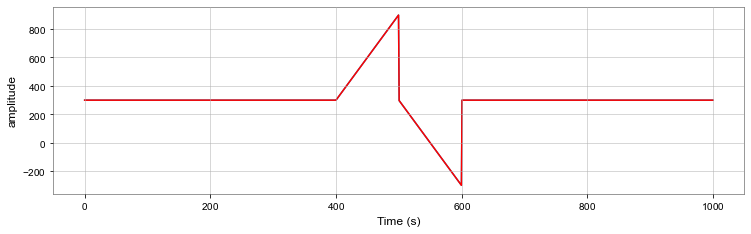

In [4]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = np.linspace(0,1000,1000)
sample_data = toy_data

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(sample_times, sample_data)
plt.xlabel('Time (s)')
plt.ylabel('amplitude')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters
### Lets fit this model to the model basically 
model = lmfit.Model(spike)
### Give it some slighlty offset parameters and it should snap to what we need
p = model.make_params()
p['offset'].set(6)
p['t0'].set(450)
p['slope'].set(7)
unc = np.full(len(sample_data),20)
out = minimize(spike_dif, params=p, args=(sample_times, toy_data, unc))
print(fit_report(out))
plt.plot(sample_times, model.eval(params=out.params,t=sample_times),'r',label='best fit')
plt.show()

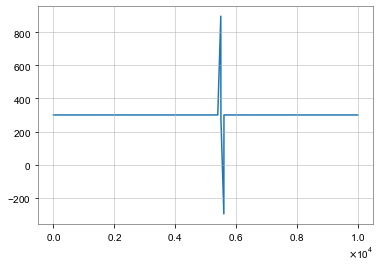

In [5]:
## Now lets buffer this data to simulate us not knowing where it is ##
data_times = np.linspace(0,10000,10000)
front_buffer = np.full(5000,300)
end_buffer = np.full(4000,300)
data = np.concatenate([front_buffer,toy_data,end_buffer])
plt.plot(data_times,data)
plt.show()

In [6]:
## Specify this buffered signal as out data ##
data_times = np.linspace(0,10000,10000)
front_buffer = np.full(5000,300)
end_buffer = np.full(4000,300)
data = np.concatenate([front_buffer,toy_data,end_buffer])

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 600
    # variables        = 3
    chi-square         = 26226.7524
    reduced chi-square = 43.9309085
    Akaike info crit   = 2272.56336
    Bayesian info crit = 2285.75415
[[Variables]]
    offset:  349.949950 +/- 5.41177165 (1.55%) (init = 300)
    slope:   2.9969e-04 +/- 0.32468896 (108341.47%) (init = 7)
    t0:      350.002121 +/- 62113.7850 (17746.69%) (init = 350)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, t0) =  0.864
0.0009230075661246493


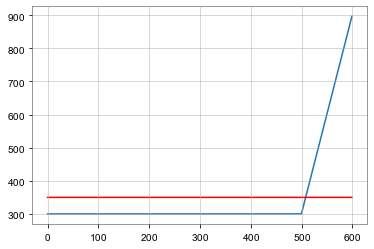

In [7]:
findxt1 = np.where((data_times >= 5200-300) & (data_times < 5200+300))
times1= data_times[findxt1]
times1 = times1 - times1[0]
window_data1 = data[findxt1]
model = lmfit.Model(spike)
p = model.make_params()
p['offset'].set(300)
p['t0'].set(350)
p['slope'].set(7)
unc = np.full(len(window_data1),20)
out = minimize(spike_dif, params=p, args=(times1, window_data1, unc))
print(fit_report(out))
plt.plot(times1,window_data1)
plt.plot(times1, model.eval(params=out.params,t=times1),'r',label='best fit')
print(abs(out.params["slope"].value/out.params["slope"].stderr))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 600
    # variables        = 3
    chi-square         = 45041.6961
    reduced chi-square = 75.4467271
    Akaike info crit   = 2597.04856
    Bayesian info crit = 2610.23935
[[Variables]]
    offset:  299.894893 +/- 7.09209549 (2.36%) (init = 300)
    slope:  -3.00360235 +/- 0.42550445 (14.17%) (init = 7)
    t0:      399.649911 +/- 8.16405738 (2.04%) (init = 350)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, t0) = -0.865
7.058921192813714


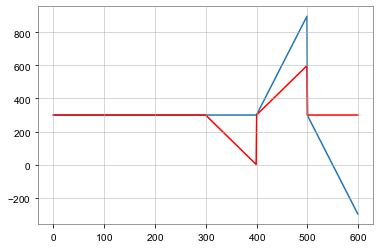

In [8]:
findxt2 = np.where((data_times >= 5300-300) & (data_times < 5300+300))
times2= data_times[findxt2]
times2 = times2 - times2[0]
window_data2 = data[findxt2]
model = lmfit.Model(spike)
p = model.make_params()
p['offset'].set(300)
p['t0'].set(350)
p['slope'].set(7)
unc = np.full(len(window_data2),20)
out = minimize(spike_dif, params=p, args=(times2, window_data2, unc))
print(fit_report(out))
plt.plot(times2,window_data2)
plt.plot(times2, model.eval(params=out.params,t=times2),'r',label='best fit')
print(abs(out.params["slope"].value/out.params["slope"].stderr))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 600
    # variables        = 3
    chi-square         = 0.02434867
    reduced chi-square = 4.0785e-05
    Akaike info crit   = -6061.32456
    Bayesian info crit = -6048.13377
[[Variables]]
    offset:  299.909910 +/- 0.00521441 (0.00%) (init = 300)
    slope:   6.00540649 +/- 3.1285e-04 (0.01%) (init = 7)
    t0:      399.584967 +/- 0.00300569 (0.00%) (init = 350)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, t0) =  0.866
19195.880231760035


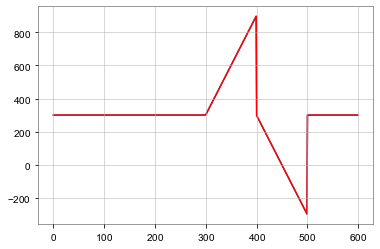

In [9]:
findxt3 = np.where((data_times >= 5400-300) & (data_times < 5400+300))
times3= data_times[findxt3]
times3 = times3 - times3[0]
window_data3 = data[findxt3]
model = lmfit.Model(spike)
p = model.make_params()
p['offset'].set(300)
p['t0'].set(350)
p['slope'].set(7)
unc = np.full(len(window_data3),20)
out = minimize(spike_dif, params=p, args=(times3, window_data3, unc))
print(fit_report(out))
plt.plot(times3,window_data3)
plt.plot(times3, model.eval(params=out.params,t=times3),'r',label='best fit')
print(abs(out.params["slope"].value/out.params["slope"].stderr))

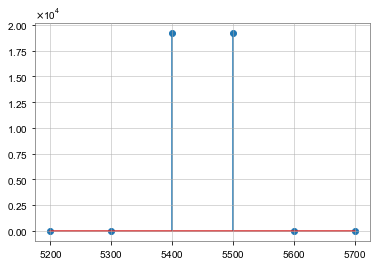

In [23]:
plt.stem([5200,5300,5400,5500,5600,5700],[0.0009230075661246493,7.058921192813714,19195.880231760035,19195.880231760035,1.2384698060976125e-06,0])
plt.show()

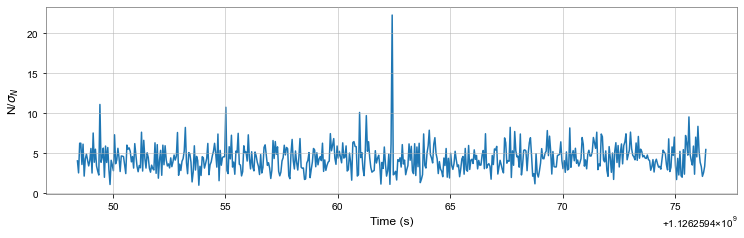

In [15]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, sigs)
plt.xlabel('Time (s)')
plt.ylabel('N/$\sigma_{N}$')
plt.show()

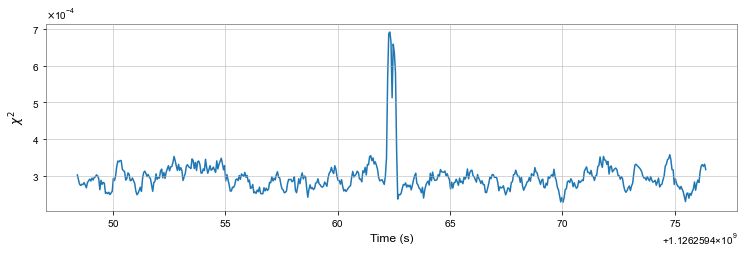

In [16]:
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, chi2)
plt.xlabel('Time (s)')
plt.ylabel('$\chi^{2}$')
plt.show()